<a href="https://colab.research.google.com/github/PTA70183292/practic/blob/main/notebooks/otchet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Преддипломная практика студента группы **о.ИЗДт 23.2/Б3-21**

**Пернеев Талгатбек Асилбекович**

на тему **«Разработка интеллектуальной системы определения эмоциональной окраски сообщений в Центре поддержки»**

На основе датасета https://huggingface.co/datasets/MonoHime/ru_sentiment_dataset

## **Установка и инициализация библиотек**
В данном блоке выполняется установка библиотек, необходимых для реализации интеллектуального сервиса анализа тональности текстов. Используются библиотеки для обработки естественного языка, машинного обучения, глубокого обучения и работы с предобученными трансформерными моделями. Установка выполняется в среде Google Colab, что обеспечивает воспроизводимость экспериментов и корректную работу всех зависимостей.

In [ ]:
!pip install -U torch torchvision torchaudio transformers datasets pymorphy3 gensim stop_words bitsandbytes

### **Импорт библиотек и настройка окружения**
В данном блоке производится импорт стандартных и специализированных библиотек, используемых на этапах подготовки данных, обучения и тестирования моделей машинного обучения. Дополнительно настраивается окружение выполнения, включая отключение лишних предупреждений и загрузку необходимых ресурсов для работы с русскоязычными текстами.

In [ ]:
import os
import re
import warnings
import math

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pymorphy3
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from gensim.models import Word2Vec
from huggingface_hub import HfApi, login
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from transformers import (AutoModelForSequenceClassification, AutoTokenizer,
                          BitsAndBytesConfig, Trainer, TrainingArguments, TrainerCallback)
os.environ["WANDB_DISABLED"] = "true"
warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('punkt_tab')
RUSSIAN_STOP_WORDS = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### **Загрузка и первичный анализ датасета**
В этом блоке загружается открытый датасет ru_sentiment_dataset, содержащий русскоязычные текстовые сообщения с разметкой по эмоциональной окраске. Выполняется первичный просмотр структуры данных, что позволяет оценить формат входных данных и пригодность датасета для решения задачи классификации тональности.

In [ ]:
dataset = load_dataset("MonoHime/ru_sentiment_dataset")

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text', 'sentiment'],
        num_rows: 189891
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'text', 'sentiment'],
        num_rows: 21098
    })
})

In [ ]:
dataset['train'][0]

{'Unnamed: 0': 21098,
 'text': '.с.,и спросил его:  о Посланник Аллаха!Ты порицаешь что-то из слушания?  Он ответил: я не порицаю ничего из него,но передай им,чтобы они открывали свои собрания Кораном и закрывали их Кораном ...........Это дошедшие до нас мнения и тот кто находится в поисках истины,по мере изучения этого вопроса будет сталкиваться с разногласиями и будет оставаться в растерянности или склонится к мнению одной из сторон по своему желанию.Но всего этого недостаточно,потому что он сам должен найти истину,подробно изучив вопросы запретного и разрешённого.|||||||||||||||||||||||||||||||||||||Обрати внимание:основатели всех четырёх мазхабов осуждали песни и поэззию.И этим часто грешат заблудшие суфии.Исключение делается для исламской тематики  Сахих БухариО проявлении радости во время праздника.498 (949). Сообщается, что ‘Аиша, да будет доволен ею Аллах, сказала: (Однажды) посланник Аллаха, да благословит его Аллах и приветствует, вошёл ко мне в то время, когда у меня находил

### Анализ распределения длины текстов и фильтрация выбросов
Для повышения качества обучения проводится анализ длины сообщений. Строится гистограмма распределения количества слов. На основе 95-го перцентиля отсеиваются аномально длинные тексты, а также удаляются слишком короткие сообщения (менее 3 слов), которые не несут достаточной семантической нагрузки для определения тональности.

In [ ]:
lengths = [len(text.split()) for text in dataset['train']['text']]
max_len = np.percentile(lengths, 95)

dataset = dataset.filter(
    lambda x: 3 <= len(x['text'].split()) <= max_len
)

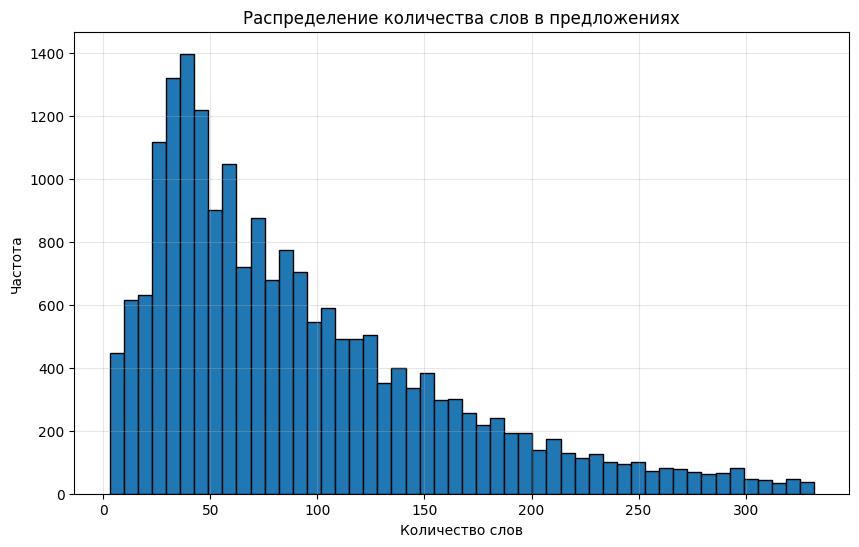

In [ ]:
texts = dataset['validation']['text']

word_counts = [len(text.split()) for text in texts]

plt.figure(figsize=(10, 6))
plt.hist(word_counts, bins=50, edgecolor='black')
plt.title('Распределение количества слов в предложениях')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
subset = dataset['train'].select(range(30000))
split_data = subset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_data['train']
test_dataset = split_data['test']

## **Лемматизация и очистка текста**
Реализован конвейер предварительной обработки текста, включающий:
Очистку от спецсимволов, цифр и латиницы с помощью регулярных выражений.
Токенизацию (разбиение на слова).
Удаление стоп-слов (предлогов, союзов), не влияющих на эмоциональную окраску.
Лемматизацию (приведение слов к нормальной форме) с использованием библиотеки pymorphy3.

In [ ]:
morph = pymorphy3.MorphAnalyzer()

def preproc_nltk(text):
    if not isinstance(text, str):
        return ""

    text = re.sub(r'@\w+\b', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'[^а-яё\s]', ' ', text, flags=re.IGNORECASE)
    text = re.sub(r'\s+', ' ', text).strip().lower()

    tokens = word_tokenize(text, language='russian')
    lemmas = [
        morph.parse(token)[0].normal_form
        for token in tokens
        if (token not in RUSSIAN_STOP_WORDS and len(token) >= 2)
    ]

    return ' '.join(lemmas)


train_dataset = train_dataset.map(lambda x: {'text': preproc_nltk(x['text'])})

In [ ]:
train_texts = train_dataset['text']
train_labels = list(train_dataset['sentiment'])

###Базовый метод: Мешок слов (Bag of Words)

В качестве базового решения (Baseline) применяется метод векторизации CountVectorizer, преобразующий текст в вектор частот слов. Для классификации используются линейные модели: Логистическая регрессия и Наивный байесовский классификатор. Данный этап необходим для оценки минимального порога точности.

In [ ]:
bow_vectorizer = CountVectorizer(
    min_df=0.05,
    max_df=0.9,
    binary=False)

bow_vectors = bow_vectorizer.fit_transform(train_texts)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(bow_vectors, train_labels, test_size=0.2, random_state=42)

In [ ]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.62625


## **Наивный байесовский классификатор на мешке слов**

In [ ]:
nb = BernoulliNB(binarize=True)
nb.fit(X_train, y_train)

BernoulliNB(binarize=True)

In [ ]:
y_pred = nb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.5041666666666667


## **TF-IDF**
Применение статистической меры TF-IDF (Term Frequency - Inverse Document Frequency) для оценки важности слов в контексте документов. Обучение классических моделей на взвешенных векторах позволяет учесть специфичные для тональности слова, снижая вес общеупотребительной лексики.

In [ ]:
vectorizer = TfidfVectorizer(min_df=50, max_df=5000)
vectors = vectorizer.fit_transform(train_dataset['text'])

In [ ]:
dense_vectors = vectors.todense()
dense_vectors.shape

(24000, 3342)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(vectors, train_labels, test_size=0.2, random_state=42)

In [ ]:
nb = BernoulliNB()
nb.fit(X_train, y_train)

BernoulliNB()

In [ ]:
y_pred = nb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.6045833333333334


In [ ]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.705625


## Использование эмбеддингов
Oбучение модели на основе самого текста

Обучение собственной модели Word2Vec на корпусе отзывов. Данный подход позволяет перевести слова в плотные векторные пространства (Embeddings), где семантически близкие слова располагаются рядом. Вектор текста формируется путем усреднения векторов входящих в него слов.

In [ ]:
proc_words = [preproc_nltk(text).split() for text in tqdm(train_dataset['text'], desc="Tokenizing")]

Tokenizing: 100%|██████████| 24000/24000 [02:11<00:00, 181.92it/s]


In [ ]:
model = Word2Vec(
    sentences=proc_words,
    vector_size=100,
    window=3,
    min_count=50,
    workers=4,
    epochs=10)

In [ ]:
def vectorize_sum(comment, embeddings, max_length=60):
    embedding_dim = embeddings.vector_size
    features = np.zeros([max_length, embedding_dim], dtype='float32')
    words = preproc_nltk(comment).split()[:max_length]

    for i, word in enumerate(words):
        if word in embeddings.wv:
            features[i] = embeddings.wv[word]

    return features

In [ ]:
X_wv = np.stack([vectorize_sum(text, model) for text in train_dataset['text']])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_wv, train_labels, test_size=0.3, random_state=0)

In [ ]:
X_train.shape

(16800, 60, 100)

In [ ]:
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)
clf.fit(X_train_flattened, y_train)
y_pred = clf.predict(X_test_flattened)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.5858333333333333


###Подготовка данных для нейронной сети Transformer
Определение гиперпараметров архитектуры модели. Создание индексированного словаря (Vocabulary) и реализация класса CommentDataset для подачи данных в нейронную сеть. Тексты преобразуются в последовательности индексов фиксированной длины (padding/truncation).

In [ ]:
MAX_LEN = 150
EMBED_DIM = 256
NHEAD = 8
FFN_HID_DIM = 256
NUM_LAYERS = 8
BATCH_SIZE = 32
EPOCHS = 25
LR = 1e-4
num_classes = 3

In [ ]:
def build_vocab(texts, min_df=2):
    vectorizer = CountVectorizer(
        min_df=min_df,
        tokenizer=lambda x: x.split(),
        token_pattern=None
    )
    vectorizer.fit(texts)
    vocab = {word: idx+2 for idx, word in enumerate(vectorizer.get_feature_names_out())}
    vocab['<pad>'] = 0
    vocab['<unk>'] = 1
    return vocab

vocab = build_vocab(train_texts)
VOCAB_SIZE = len(vocab)

In [ ]:
VOCAB_SIZE

31143

In [ ]:
class CommentDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = self.texts[idx].split()
        token_ids = [self.vocab.get(t, self.vocab['<unk>']) for t in tokens[:self.max_len]]

        if len(token_ids) < self.max_len:
            token_ids += [self.vocab['<pad>']] * (self.max_len - len(token_ids))

        return {
            'input_ids': torch.tensor(token_ids, dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_texts_list = list(train_dataset['text'])
train_labels_list = list(train_dataset['sentiment'])

texts_train, texts_val, labels_train, labels_val = train_test_split(
    train_texts_list,
    train_labels_list,
    test_size=0.1,
    random_state=42
)

train_data = CommentDataset(texts_train, labels_train, vocab, MAX_LEN)
val_data = CommentDataset(texts_val, labels_val, vocab, MAX_LEN)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

###Реализация архитектуры Transformer «с нуля»
Программная реализация ключевых компонентов архитектуры Transformer на базе torch.nn.Module:
MultiHeadAttentionLayer: Механизм многоголового внимания для учета контекста.
PositionalEncoding: Добавление информации о порядке слов в предложении.
EncoderBlock: Блок кодировщика с нормализацией и полносвязными слоями.
TextTransformer: Итоговая модель классификатора.

In [ ]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()

        assert hid_dim % n_heads == 0

        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads

        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        self.fc_o = nn.Linear(hid_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value):
        batch_size = query.shape[0]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        attention = torch.softmax(energy, dim=-1)
        x = torch.matmul(self.dropout(attention), V)

        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(batch_size, -1, self.hid_dim)
        x = self.fc_o(x)

        return x, attention

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, emb_size, nhead, dim_feedforward=128, dropout=0.2):
        super().__init__()
        self.self_attn = MultiHeadAttentionLayer(emb_size, nhead, dropout, device=device)
        self.linear1 = nn.Linear(emb_size, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, emb_size)
        self.norm1 = nn.LayerNorm(emb_size)
        self.norm2 = nn.LayerNorm(emb_size)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()

    def forward(self, src):
        src2, _ = self.self_attn(src, src, src)
        src = self.norm1(src + self.dropout(src2))

        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = self.norm2(src + self.dropout(src2))
        return src


class PositionalEncoding(nn.Module):
    def __init__(self, emb_size, max_len):
        super().__init__()
        pe = torch.zeros(max_len, emb_size)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_size, 2).float() * (-math.log(10000.0) / emb_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [ ]:
class TextTransformer(nn.Module):
    def __init__(self, num_classes, vocab_size, emb_size, nhead, num_layers, dim_feedforward, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.pos_encoder = PositionalEncoding(emb_size, MAX_LEN)

        self.layers = nn.ModuleList([
            EncoderBlock(emb_size, nhead, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])

        self.classifier = nn.Linear(emb_size, num_classes)

    def forward(self, src):
        src = self.embedding(src)
        src = self.pos_encoder(src)

        for layer in self.layers:
            src = layer(src)

        output = src.mean(dim=1)
        return self.classifier(output)

###Обучение кастомной модели Transformer
Инициализация модели, функции потерь (CrossEntropy) и оптимизатора (Adam). Запуск цикла обучения с валидацией на каждой эпохе. Данный этап демонстрирует возможность достижения целевых метрик (Accuracy >= 70%) с использованием собственной архитектуры.

In [ ]:
model = TextTransformer(
    num_classes=num_classes,
    vocab_size=VOCAB_SIZE,
    emb_size=EMBED_DIM,
    nhead=NHEAD,
    num_layers=NUM_LAYERS,
    dim_feedforward=FFN_HID_DIM
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [ ]:
model = TextTransformer(
    num_classes=num_classes,
    vocab_size=VOCAB_SIZE,
    emb_size=EMBED_DIM,
    nhead=NHEAD,
    num_layers=NUM_LAYERS,
    dim_feedforward=FFN_HID_DIM
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [ ]:
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (torch.argmax(outputs, dim=1) == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total

    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids)
            predicted = torch.argmax(outputs, dim=1)

            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total if val_total > 0 else 0

    print(f"Epoch {epoch+1}, "
          f"Loss: {total_loss/len(train_loader):.4f}, "
          f"Train Acc: {train_acc:.2f}%, "
          f"Val Acc: {val_acc:.2f}%")

Epoch 1 [Val]: 100%|██████████| 75/75 [00:01<00:00, 46.36it/s]


Epoch 1, Loss: 0.8259, Train Acc: 58.58%, Val Acc: 66.67%


Epoch 2 [Val]: 100%|██████████| 75/75 [00:01<00:00, 44.60it/s]


Epoch 2, Loss: 0.6503, Train Acc: 69.00%, Val Acc: 70.83%


Epoch 3 [Val]: 100%|██████████| 75/75 [00:01<00:00, 42.69it/s]


Epoch 3, Loss: 0.5705, Train Acc: 73.06%, Val Acc: 71.46%


Epoch 4 [Val]: 100%|██████████| 75/75 [00:01<00:00, 41.55it/s]


Epoch 4, Loss: 0.4997, Train Acc: 77.02%, Val Acc: 73.38%


Epoch 5 [Val]: 100%|██████████| 75/75 [00:01<00:00, 42.31it/s]


Epoch 5, Loss: 0.4271, Train Acc: 80.97%, Val Acc: 72.12%


Epoch 6 [Val]: 100%|██████████| 75/75 [00:01<00:00, 42.50it/s]


Epoch 6, Loss: 0.3639, Train Acc: 84.09%, Val Acc: 72.42%


Epoch 7 [Val]: 100%|██████████| 75/75 [00:01<00:00, 42.49it/s]


Epoch 7, Loss: 0.3062, Train Acc: 87.04%, Val Acc: 72.54%


Epoch 8 [Val]: 100%|██████████| 75/75 [00:01<00:00, 42.56it/s]


Epoch 8, Loss: 0.2530, Train Acc: 89.57%, Val Acc: 71.38%


Epoch 9 [Val]: 100%|██████████| 75/75 [00:01<00:00, 41.85it/s]


Epoch 9, Loss: 0.2050, Train Acc: 91.82%, Val Acc: 72.08%


Epoch 10 [Val]: 100%|██████████| 75/75 [00:01<00:00, 41.92it/s]


Epoch 10, Loss: 0.1647, Train Acc: 93.62%, Val Acc: 70.67%


Epoch 11 [Val]: 100%|██████████| 75/75 [00:01<00:00, 42.67it/s]


Epoch 11, Loss: 0.1395, Train Acc: 94.79%, Val Acc: 70.88%


Epoch 12 [Val]: 100%|██████████| 75/75 [00:01<00:00, 42.55it/s]


Epoch 12, Loss: 0.1189, Train Acc: 95.66%, Val Acc: 71.00%


Epoch 13 [Val]: 100%|██████████| 75/75 [00:01<00:00, 42.63it/s]


Epoch 13, Loss: 0.1019, Train Acc: 96.33%, Val Acc: 69.54%


Epoch 14 [Val]: 100%|██████████| 75/75 [00:01<00:00, 42.61it/s]


Epoch 14, Loss: 0.0901, Train Acc: 96.67%, Val Acc: 70.67%


Epoch 15 [Val]: 100%|██████████| 75/75 [00:01<00:00, 41.52it/s]


Epoch 15, Loss: 0.0755, Train Acc: 97.30%, Val Acc: 70.50%


Epoch 16 [Val]: 100%|██████████| 75/75 [00:01<00:00, 42.42it/s]


Epoch 16, Loss: 0.0680, Train Acc: 97.52%, Val Acc: 72.12%


Epoch 17 [Val]: 100%|██████████| 75/75 [00:01<00:00, 42.57it/s]


Epoch 17, Loss: 0.0653, Train Acc: 97.79%, Val Acc: 71.21%


Epoch 18 [Val]: 100%|██████████| 75/75 [00:01<00:00, 42.39it/s]


Epoch 18, Loss: 0.0618, Train Acc: 97.74%, Val Acc: 71.12%


Epoch 19 [Val]: 100%|██████████| 75/75 [00:01<00:00, 42.60it/s]


Epoch 19, Loss: 0.0619, Train Acc: 97.69%, Val Acc: 71.42%


Epoch 20 [Val]: 100%|██████████| 75/75 [00:01<00:00, 41.67it/s]


Epoch 20, Loss: 0.0514, Train Acc: 98.07%, Val Acc: 71.42%


Epoch 21 [Val]: 100%|██████████| 75/75 [00:01<00:00, 41.93it/s]


Epoch 21, Loss: 0.0479, Train Acc: 98.26%, Val Acc: 70.79%


Epoch 22 [Val]: 100%|██████████| 75/75 [00:01<00:00, 42.56it/s]


Epoch 22, Loss: 0.0482, Train Acc: 98.17%, Val Acc: 70.75%


Epoch 23 [Val]: 100%|██████████| 75/75 [00:01<00:00, 40.26it/s]


Epoch 23, Loss: 0.0466, Train Acc: 98.16%, Val Acc: 69.75%


Epoch 24 [Val]: 100%|██████████| 75/75 [00:01<00:00, 41.79it/s]


Epoch 24, Loss: 0.0475, Train Acc: 98.15%, Val Acc: 70.75%


Epoch 25 [Val]: 100%|██████████| 75/75 [00:01<00:00, 42.15it/s]

Epoch 25, Loss: 0.0438, Train Acc: 98.29%, Val Acc: 70.83%


###Тестирование предобученных моделей без дообучения
Загрузка "тяжелых" моделей (BERT Multilingual, RuBERT) и проверка их работы на целевой задаче без этапа обучения (Fine-tuning). Данный эксперимент призван продемонстрировать, что без настройки весов классификационного слоя ("головы") модели показывают результат на уровне случайного угадывания, что обосновывает необходимость дальнейшего обучения.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

## **Создадим фукнцию**

In [ ]:
test_texts = test_dataset['text']
test_labels = test_dataset['sentiment']

###Проверка работы квантованных моделей (8-bit)
Тестирование возможности загрузки больших языковых моделей (LLM) в режиме 8-битного квантования с использованием библиотеки bitsandbytes. Это технический этап, подтверждающий возможность запуска моделей на доступном оборудовании (GPU с ограниченной памятью) перед началом процесса дообучения.

In [ ]:
def test_model(model_name, test_texts, test_labels, batch_size):
  try:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=3,
        )
        model.to(device)
        model.eval()
        predictions = []
        for i in tqdm(range(0, len(test_texts), batch_size)):
            batch_texts = test_texts[i:i + batch_size]

            inputs = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=256,
                return_tensors="pt"
            ).to(device)

            with torch.no_grad():
                outputs = model(**inputs)
                batch_predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
                predictions.extend(batch_predictions)

        predictions = np.array(predictions)
        acc = accuracy_score(test_labels, predictions)
        f1_m = f1_score(test_labels, predictions, average='macro')
        f1_w = f1_score(test_labels, predictions, average='weighted')
        print(classification_report(
            test_labels,
            predictions,
            target_names=['Позитивный', 'Нейтральный', 'Негативный'],
            digits=4
        ))
        return {
            'model': model_name,
            'accuracy': acc,
            'f1_macro': f1_m,
            'f1_weighted': f1_w,
            'predictions': predictions
        }

  except Exception as e:
    print(f"{model}: {e}")
    return None

In [ ]:
models = {
    "BERT Мультиязычный": "bert-base-multilingual-cased",
    "RuBERT": "DeepPavlov/rubert-base-cased",
    "RuBERT на диалогах": "DeepPavlov/rubert-base-cased-conversational"
}

In [ ]:
results = {}

for model_label, model_name in models.items():
    result = test_model(model_name, test_texts, test_labels, batch_size=32)
    if result:
        results[model_label] = result

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/188 [00:00<?, ?it/s]

              precision    recall  f1-score   support

  Позитивный     0.2518    0.9214    0.3955      1514
 Нейтральный     0.4923    0.0220    0.0422      2903
  Негативный     0.2462    0.0512    0.0847      1583

    accuracy                         0.2567      6000
   macro avg     0.3301    0.3315    0.1741      6000
weighted avg     0.3667    0.2567    0.1426      6000



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/188 [00:00<?, ?it/s]

              precision    recall  f1-score   support

  Позитивный     0.2327    0.0779    0.1168      1514
 Нейтральный     0.4766    0.0982    0.1628      2903
  Негативный     0.2478    0.7663    0.3745      1583

    accuracy                         0.2693      6000
   macro avg     0.3190    0.3141    0.2180      6000
weighted avg     0.3547    0.2693    0.2070      6000



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/188 [00:00<?, ?it/s]

              precision    recall  f1-score   support

  Позитивный     0.2194    0.4478    0.2945      1514
 Нейтральный     0.4130    0.2329    0.2978      2903
  Негативный     0.3794    0.3051    0.3382      1583

    accuracy                         0.3062      6000
   macro avg     0.3373    0.3286    0.3102      6000
weighted avg     0.3553    0.3062    0.3076      6000



## **Квантованные версии моделей**

In [ ]:
def test_quantized_model(model_name, test_texts, test_labels, batch_size=16):

    try:
        quantization_config = BitsAndBytesConfig(
            load_in_8bit=True,
            llm_int8_threshold=6.0,
            llm_int8_skip_modules=None,
            llm_int8_has_fp16_weight=False
        )

        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=3,
            quantization_config=quantization_config,
            device_map="auto",
            ignore_mismatched_sizes=True
        )
        model.eval()

        predictions = []

        for i in tqdm(range(0, len(test_texts), batch_size)):
            batch_texts = test_texts[i:i + batch_size]

            inputs = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=256,
                return_tensors="pt"
            )

            inputs = {k: v.to(model.device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = model(**inputs)
                batch_predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
                predictions.extend(batch_predictions)

        predictions = np.array(predictions)

        accuracy = accuracy_score(test_labels, predictions)
        f1_macro = f1_score(test_labels, predictions, average='macro')
        f1_weighted = f1_score(test_labels, predictions, average='weighted')

        print(classification_report(
            test_labels,
            predictions,
            target_names=['Позитивный', 'Нейтральный', 'Негативный'],
            digits=4
        ))

        if torch.cuda.is_available():
            memory_allocated = torch.cuda.memory_allocated() / 1024**3

        del model
        torch.cuda.empty_cache()

        return {
            'model': model_name,
            'accuracy': accuracy,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted,
            'predictions': predictions
        }

    except Exception as e:
        print(f"Ошибка при тестировании {model_name}: {e}")
        import traceback
        traceback.print_exc()
        return None

In [ ]:
models = {
    "BERT Мультиязычный": "bert-base-multilingual-cased",
    "RuBERT": "DeepPavlov/rubert-base-cased",
    "RuBERT на диалогах": "DeepPavlov/rubert-base-cased-conversational"
}

In [ ]:
results = {}

for model_label, model_name in models.items():
    result = test_quantized_model(model_name, test_texts, test_labels, batch_size=16)
    if result:
        results[model_label] = result

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/375 [00:00<?, ?it/s]

              precision    recall  f1-score   support

  Позитивный     0.2501    0.6790    0.3655      1514
 Нейтральный     0.4870    0.2256    0.3084      2903
  Негативный     0.2408    0.0828    0.1232      1583

    accuracy                         0.3023      6000
   macro avg     0.3260    0.3291    0.2657      6000
weighted avg     0.3623    0.3023    0.2739      6000



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/375 [00:00<?, ?it/s]

              precision    recall  f1-score   support

  Позитивный     0.2555    0.5291    0.3446      1514
 Нейтральный     0.5260    0.0524    0.0952      2903
  Негативный     0.2690    0.4378    0.3333      1583

    accuracy                         0.2743      6000
   macro avg     0.3502    0.3397    0.2577      6000
weighted avg     0.3899    0.2743    0.2210      6000



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/375 [00:00<?, ?it/s]

              precision    recall  f1-score   support

  Позитивный     0.2537    0.7219    0.3755      1514
 Нейтральный     0.4905    0.2590    0.3390      2903
  Негативный     0.2642    0.0265    0.0482      1583

    accuracy                         0.3145      6000
   macro avg     0.3361    0.3358    0.2542      6000
weighted avg     0.3711    0.3145    0.2715      6000



In [ ]:
results_data = {
    model: {
        'acc': info['accuracy'],
        'f1_m': info['f1_macro'],
        'f1_w': info['f1_weighted']
    }
class LogAccuracyCallback(TrainerCallback):
    def on_evaluate(self, args, state, control, metrics, **kwargs):
        acc = metrics.get("eval_accuracy")
        f1_macro = metrics.get("eval_f1_macro", 0)
        if acc is not None:
            print(f" Epoch {int(state.epoch)} - Eval Accuracy: {acc:.4f} | F1-macro: {f1_macro:.4f}")    for model, info in results.items()
}

In [ ]:
!pip install peft

###Дообучение модели (Fine-tuning) с использованием методов QLoRA и PEFT
Дообучение модели выполнено с использованием методов QLoRA и PEFT. Базовая модель BERT загружается в 8-битном формате, а обучение осуществляется только для адаптационных LoRA-слоёв с применением Hugging Face Trainer, что обеспечивает снижение вычислительных затрат при сохранении качества классификации.

In [ ]:
class LogAccuracyCallback(TrainerCallback):
    def on_evaluate(self, args, state, control, metrics, **kwargs):
        acc = metrics.get("eval_accuracy")
        f1_macro = metrics.get("eval_f1_macro", 0)
        if acc is not None:
            print(f"Epoch {int(state.epoch)} - Eval Accuracy: {acc:.4f} | F1-macro: {f1_macro:.4f}")

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1_macro': f1_score(labels, preds, average='macro'),
        'f1_weighted': f1_score(labels, preds, average='weighted')
    }

def preprocess(examples, tokenizer):
    tokenized = tokenizer(examples['text'], truncation=True, padding='max_length', max_length=256)
    tokenized['labels'] = examples['sentiment']
    return tokenized

model_name = "DeepPavlov/rubert-base-cased-conversational"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenized_train = train_dataset.map(lambda x: preprocess(x, tokenizer), batched=True, remove_columns=['text', 'Unnamed: 0'])
tokenized_test = test_dataset.map(lambda x: preprocess(x, tokenizer), batched=True, remove_columns=['text', 'Unnamed: 0'])

!pip install -U bitsandbytes
bnb_config = BitsAndBytesConfig(load_in_8bit=True, llm_int8_threshold=6.0)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3, quantization_config=bnb_config, device_map="auto")
model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(r=32, lora_alpha=64, target_modules=["query", "key", "value", "dense"], lora_dropout=0.1, bias="none", task_type="SEQ_CLS")
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

training_args = TrainingArguments(
    output_dir="./results/BERT_QLoRA",
    num_train_epochs=2,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=1,

    warmup_steps=200,
    weight_decay=0.01,
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    learning_rate=2e-4,
    max_grad_norm=0.3,
    report_to="none"
)

trainer = Trainer(model=model, args=training_args, train_dataset=tokenized_train, eval_dataset=tokenized_test, compute_metrics=compute_metrics, callbacks=[LogAccuracyCallback()])
trainer.train()

predictions = trainer.predict(tokenized_test)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

print(f"\nF1-macro: {predictions.metrics['test_f1_macro']:.4f}")
print(f"F1-weighted: {predictions.metrics['test_f1_weighted']:.4f}")
print("\n", classification_report(true_labels, pred_labels, target_names=['Позитивный', 'Нейтральный', 'Негативный'], digits=4))

model.save_pretrained("./results/BERT_QLoRA")
tokenizer.save_pretrained("./results/BERT_QLoRA")

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 5,359,875 || all params: 183,215,622 || trainable%: 2.9254


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.553000,0.513491,0.763833,0.751556,0.765618
2,0.464800,0.477151,0.774500,0.770353,0.778917


Epoch 1 - Eval Accuracy: 0.7638 | F1-macro: 0.7516
Epoch 2 - Eval Accuracy: 0.7745 | F1-macro: 0.7704



F1-macro: 0.7704
F1-weighted: 0.7789

               precision    recall  f1-score   support

  Позитивный     0.6113    0.7873    0.6882      1514
 Нейтральный     0.8468    0.7671    0.8050      2903
  Негативный     0.8648    0.7757    0.8178      1583

    accuracy                         0.7745      6000
   macro avg     0.7743    0.7767    0.7704      6000
weighted avg     0.7921    0.7745    0.7789      6000



('./results/BERT_QLoRA/tokenizer_config.json',
 './results/BERT_QLoRA/special_tokens_map.json',
 './results/BERT_QLoRA/vocab.txt',
 './results/BERT_QLoRA/added_tokens.json',
 './results/BERT_QLoRA/tokenizer.json')

###Сохранение модели и публикация
Сохранение весов обученных адаптеров и конфигурации токенизатора локально. Загрузка (Push) готовой модели в репозиторий Hugging Face Hub для дальнейшего использования в веб-приложении и развертывания.

***Модель уже ранее была загружена в
https://huggingface.co/egdfgdfgdsfg/rubert-base-cased-conversational с выполнением 2 блоков ниже (требуется токен)***



In [ ]:
"""login()"""

In [ ]:
"""api = HfApi()

repo_id = "egdfgdfgdsfg/rubert-base-cased-conversational"
api.create_repo(repo_id=repo_id, repo_type="model", exist_ok=True)

api.upload_folder(
    folder_path="./results/BERT_QLoRA",
    repo_id=repo_id,
    repo_type="model"
    )"""

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...int-940/training_args.bin: 100%|##########| 5.84kB / 5.84kB            

  ...ckpoint-564/rng_state.pth: 100%|##########| 14.6kB / 14.6kB            

  .../checkpoint-564/scaler.pt: 100%|##########| 1.38kB / 1.38kB            

  ...eckpoint-564/scheduler.pt: 100%|##########| 1.47kB / 1.47kB            

  ...int-564/training_args.bin: 100%|##########| 5.84kB / 5.84kB            

  ...kpoint-1500/rng_state.pth: 100%|##########| 14.6kB / 14.6kB            

  ...ckpoint-1500/scheduler.pt: 100%|##########| 1.47kB / 1.47kB            

  ...adapter_model.safetensors: 100%|##########|  606kB /  606kB            

  ...eckpoint-188/optimizer.pt: 100%|##########| 1.24MB / 1.24MB            

  ...ckpoint-188/rng_state.pth: 100%|##########| 14.6kB / 14.6kB            

CommitInfo(commit_url='https://huggingface.co/egdfgdfgdsfg/rubert-base-cased-conversational/commit/4b1bf4934815d373a9c926e22d3d042326dcfaf6', commit_message='Upload folder using huggingface_hub', commit_description='', oid='4b1bf4934815d373a9c926e22d3d042326dcfaf6', pr_url=None, repo_url=RepoUrl('https://huggingface.co/egdfgdfgdsfg/rubert-base-cased-conversational', endpoint='https://huggingface.co', repo_type='model', repo_id='egdfgdfgdsfg/rubert-base-cased-conversational'), pr_revision=None, pr_num=None)